# Soluciones al examen de OPI 

In [86]:
# paquetes necesarios para este examen
import pandas as pd
from datetime import datetime # para que Python reconozca las fechas
import numpy as np
import math
import matplotlib.pyplot as plt

In [346]:
# Función que se necesitará más adelante para agregar formato a la fec
def cambio_mes(mes):
    reemplazo = (
            ('Enero', '01'),
            ('Febrero', '02'),
            ('Marzo', '03'),
            ('Abril', '04'),
            ('Mayo', '05'),
            ('Junio','06'),
            ('Julio','07'),
            ('Agosto','08'),
            ('Septiembre','09'),
            ('Octubre', '10'),
            ('Noviembre','11'),
            ('Diciembre', '12')
        )
    for a, b in reemplazo:
        mes = mes.replace(a, b)
    return mes
cambio_mes.__doc__ = "Cambia el mes a su correspondiente valor numerico"

1. Los datos son de calidad cuando sirven para una finalidad prevista, basados en las siguientes características:
* No debe haber huecos, ni variables repetidas.
* La información debe ser relevante para cumplir los objetivos, por ejemplo, si estoy haciendo un análisis sobre los delitos en la ciudad de México, no me sirve tener información sobre el peso de los habitantes de la ciudad.
* Confiabilidad: hay que asegurarse que los datos no sean ambiguos, vagos o que contengan información contradictoria, por ejemplo, si tengo información sobre los delitos de una alcaldía en dos columnas y cada una con información diferente.
* Los datos tienen que ser colectados en el tiempo correcto, hay que asegurarse que no sean obsoletos, tomando de nuevo el análisis de los delitos de la CDMX, no tendría sentido que sólo tenga información de hace 30 años.

2. Datos a la alza y a la baja.

In [25]:
# importamos la base de datos
# encoding='utf-8' es para que al importarse la base de datos, reconozca caracteres 
# como la ñ.
# dtype='unicode' es para evitar un warning por low_memory ya que python estaba 
# adivinando el tipo de objeto (dtype) de cada columna

datos = pd.read_csv('/home/lorena/Escritorio/OPI/carpetas_completa_febrero_2022.csv', encoding='utf-8', dtype='unicode')

Para que las columnas fecha_hechos y fecha_inicia tal cual sean reconocidas como fechas, se utiliza la función de pandas **to_datetime**.

In [30]:
datos['fecha_hechos'] = pd.to_datetime(datos['fecha_hechos'], format = "%Y %m %d %H:%M:%S")
datos['fecha_inicio'] = pd.to_datetime(datos['fecha_inicio'], format = "%Y %m %d %H:%M:%S")

In [241]:
datos.set_index(datos['mes_hechos']+'/'+datos['ao_hechos'], inplace = True)

In [28]:
datos.columns

Index(['ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio', 'mes_inicio',
       'fecha_inicio', 'delito', 'fiscalia', 'agencia', 'unidad_investigacion',
       'categoria_delito', 'calle_hechos', 'calle_hechos2', 'colonia_hechos',
       'alcaldia_hechos', 'competencia', 'longitud', 'latitud', 'tempo'],
      dtype='object')

A continuación, descarto a aquellas filas en las que el año de los hechos sea igual a **nan**:

In [108]:
datos = datos[np.logical_not(pd.isnull(datos['ao_hechos']))]

Agrupando la base de datos primero por delito, después por año de los hechos y por último por mes de los hechos. Una vez organizada la base, se cuenta las veces que se repite cada delito de acuerdo al mes y al año. Al resultado le asigné la variable **delitos_fr**, ya que obtenemos la frecuencia de los delitos.

In [384]:
delitos_fr = datos.groupby(['delito','ao_hechos','mes_hechos'], as_index=False, group_keys=True).size()

En **delitos_fr** aplicamos la función **cambio_mes** para que fila a fila se cambie el formato del mes a numérico:

In [385]:
delitos_fr['mes_hechos'] = delitos_fr['mes_hechos'].apply(cambio_mes)

Para que sea más sencillos seleccionar la frecuencia de acuerdo al delito, hice una lista con el nombre de estos:

In [389]:
delitos = delitos_fr['delito'].unique()

## Prueba con un sólo delito

Antes de manipular los datos delito a delito, comencé con el primero del arreglo **delitos**. Así que primero seleccioné de **delitos_fr** el subgrupo del primer delito.

In [390]:
primer_delito = delitos_fr[delitos_fr['delito'] == delitos[0]]

In [492]:
segundo_delito = delitos_fr[delitos_fr['delito'] == delitos[1]]

Después definí los índices para **delitos_fr**, siendo la fecha.

In [392]:
primer_delito.set_index(pd.to_datetime(primer_delito['mes_hechos']+'/'+primer_delito['ao_hechos'], format = '%m/%Y'), inplace = True)

In [493]:
segundo_delito.set_index(pd.to_datetime(segundo_delito['mes_hechos']+'/'+segundo_delito['ao_hechos'], format = '%m/%Y'), inplace = True)

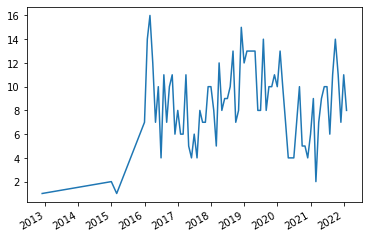

In [497]:
segundo_delito['size'].plot()
plt.show()

### Eliminación de outliers

Cuando se construye una caja de bigotes para ver cómo se encuentran distribuidos los datos, los datos atípicos (outliers) se encuentran por debajo de la diferencia del primer cuartil, menos 1.5 el rango intercuartil, o por encima de la suma del cuartil 3 más 1.5 veces el rango intercuartil. Al hacer una caja de bigotes para el primer delito seleccionado:

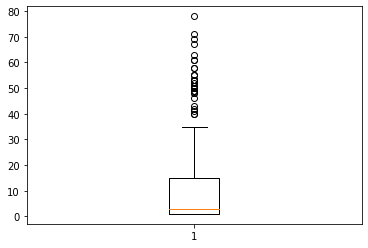

In [476]:
plt.boxplot(primer_delito['size'])
plt.show()

Vemos que los outliers sólo se encuentran hacia arriba, lo que quiere decir es que hay muchos mediciones con ocurrencias bajas, que hacen que el primer cuartil tenga un valor bajo. Observemos los valores del primer cuartil (percentil 25):

In [489]:
primer_delito.describe()

,size
count,162.000000
mean,14.666667
std,20.980026
min,1.000000
25%,1.000000
50%,3.000000
75%,15.000000
max,78.000000


In [491]:
sum(primer_delito['size'])

2376

Vemos que vale 1, mientras que la mediana (percentil 50) vale 3, por lo que efectivamente hay muchas ocurrencias bajas y por lo tanto ya no se identifican como valores atípicos. También vemos que el rango de ocurrencias (valor máximo - valor mínimo) es de 77, así que para que la distribución de los datos tenga más sentido para ser analizados, descartaremos aquellos datos con ocurrencias tan bajas que provoquen que la media de los datos no se acerque a la media del rango (38 redondeando hacia abajo). Podemos fijar un límite inferior en el que sea válido mantener las ocurrencias, 6 unidades parece suficiente, así que descartaremos las ocurrencias bajas hasta que la media sea de 32 o superior.

Podemos recurrir a la gráfica de las ocurrencias de este delito para ver cómo se encuentran distribuidos los datos:

In [488]:
round((max(primer_delito['size'])-min(primer_delito['size']))/2)

38

In [ ]:
media = np.mean(primer_delito['size'])
while media < round((max(primer_delito['size'])-min(primer_delito['size']))/2):

In [455]:
primer_delito[primer_delito['size'].apply(lambda x: x > 1)]

,delito,ao_hechos,mes_hechos,size
2004-03-01,ABANDONO DE PERSONA,2004,03,2
2004-11-01,ABANDONO DE PERSONA,2004,11,3
2005-03-01,ABANDONO DE PERSONA,2005,03,2
2007-08-01,ABANDONO DE PERSONA,2007,08,4
2007-01-01,ABANDONO DE PERSONA,2007,01,2
...,...,...,...,...
2018-03-01,ABANDONO DE PERSONA,2018,03,48
2018-05-01,ABANDONO DE PERSONA,2018,05,61
2018-11-01,ABANDONO DE PERSONA,2018,11,50
2018-10-01,ABANDONO DE PERSONA,2018,10,53


In [464]:
primer_delito_filtrado = primer_delito[primer_delito['size'].apply(lambda x: x > 4)]

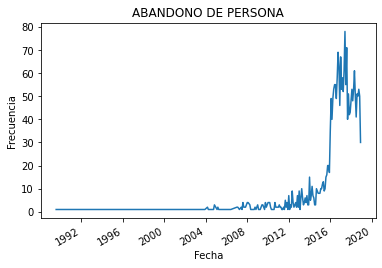

In [490]:
primer_delito['size'].plot()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title(delitos[0])
plt.show()

Vemos que justo hay muchas mediciones con rangos bajos que se ven casi como una constante a lo largo del eje horizontal, esto afectará al momento de analizar el comportamiento de las ocurrencias del delito.

Hice una gráfica de la frecuencia para el primer delito, para confirmar que todo, está bien. **Nota**: más adelante si es necesario, quitaré esta gráfica.

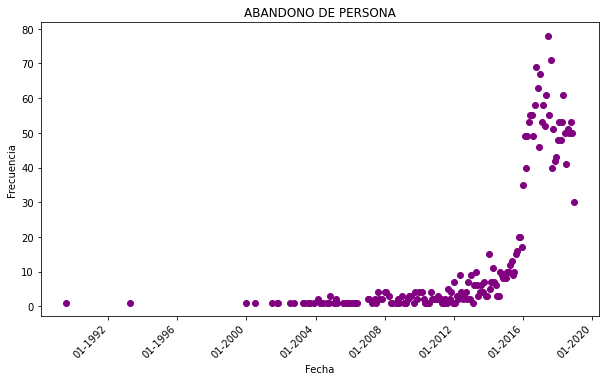

In [502]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(primer_delito.index,
        primer_delito['size'],
        color='purple')
ax.set(xlabel="Fecha", ylabel="Frecuencia",
       title=delitos[0])

# Formato para el eje x
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
fig.autofmt_xdate(rotation=45)

plt.show()

In [503]:
import statsmodels.formula.api as smf

In [ ]:
y = primer_delito['size']
x = 
model = smf.ols(' ~ TV', data=advert)
model = model.fit()

In [ ]:
pip install financialanalysis

In [506]:
from sklearn.linear_model import LinearRegression

In [543]:
X = np.arange(len(primer_delito.index)).reshape((-1,1))  # features
y = primer_delito['size']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=primer_delito.index)

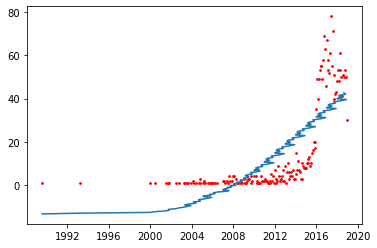

In [544]:
plt.plot(y_pred)
plt.scatter(primer_delito.index,primer_delito['size'], color = 'red', s = 3)
plt.show()

Abajo dejé algunos datos extras por si los necesito a futuro:

In [110]:
# arreglo con los años de los hechos que aparecen en la base de datos, sin repetir
año_hechos = datos['ao_hechos'].unique()

In [111]:
año_hechos

array(['2016', '2015', '2012', '2014', '2011', '2008', '2006', '2010',
       '2013', '2005', '2009', '1955', '2004', '2002', '1998', '1997',
       '1965', '2007', '2000', '1987', '1999', '1956', '2001', '1996',
       '1986', '1915', '1988', '2017', '2003', '1991', '1993', '1977',
       '1984', '1995', '1994', '1990', '1992', '1978', '1989', '1972',
       '2018', '2019', '1974', '1970', '1980', '1976', '1983', '1985',
       '1966', '1969', '1981', '1960', '1982', '1975', '1954', '1973',
       '1964', '1968', '1963', '1971', '1958', '1942', '1930', '1979',
       '1906', '1962', '1957', '2020', '1950', '1952', '2021', '1967',
       '1961', '1917', '2022'], dtype=object)

In [57]:
# arreglo con los años de inicio que aparecen en la base de datos, sin repetir
año_inicio = datos['ao_inicio'].unique()

In [58]:
año_inicio

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)